In [20]:
# CLUSTERING
# it is an unsupervised technique to analyze and label data. when you don't know anything about a dataset, try to find clusters

import data_lib
from data_lib import Vector
from typing import List, NamedTuple, Union, Callable, Tuple
import math
import random
import tqdm
import itertools

# there are multiple ways to assign n points to k clusters
# one of the most used is k-means. it aims to partition the dataset in k clusters in which each observtion belongs to the cluster with the nearest mean
def num_differences(v1: Vector, v2: Vector) -> int:
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])

assert num_differences([1, 2, 3], [2, 1, 3]) == 2
assert num_differences([1, 2], [1, 2]) == 0

def cluster_means(k: int,
                  inputs: List[Vector],
                  assignments: List[int]) -> List[Vector]:
    # clusters[i] contains the inputs whose assignment is i
    clusters = [[] for i in range(k)]
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)

    # if a cluster is empty, just use a random point
    return [data_lib.vector_mean(cluster) if cluster else random.choice(inputs)
            for cluster in clusters]

In [21]:
class KMeans:
    def __init__(self, k: int) -> None:
        self.k = k                      # number of clusters
        self.means = None

    def classify(self, input: Vector) -> int:
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: data_lib.squared_distance(input, self.means[i]))

    def train(self, inputs: List[Vector]) -> None:
        # Start with random assignments
        assignments = [random.randrange(self.k) for _ in inputs]

        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # Compute means and find new assignments
                self.means = cluster_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input) for input in inputs]

                # Check how many assignments changed and if we're done
                num_changed = num_differences(assignments, new_assignments)
                if num_changed == 0:
                    return

                # Otherwise keep the new assignments, and compute new means
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"changed: {num_changed} / {len(inputs)}")

In [22]:
# example: we want to do 3 meetups, in inputs we have the coordinates of where people leaves. let's find the best places
inputs: List[List[float]] = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

random.seed(12)                   # so you get the same results as me
clusterer = KMeans(k=3)
clusterer.train(inputs)
means = sorted(clusterer.means)   # sort for the unit test

assert len(means) == 3
# Check that the means are close to what we expect
assert data_lib.squared_distance(means[0], [-44, 5]) < 1
assert data_lib.squared_distance(means[1], [-16, -10]) < 1
assert data_lib.squared_distance(means[2], [18, 20]) < 1

# now, let's try for 2 meetups
random.seed(0)
clusterer = KMeans(k=2)
clusterer.train(inputs)
means = sorted(clusterer.means)

assert len(means) == 2
assert data_lib.squared_distance(means[0], [-26, -5]) < 1
assert data_lib.squared_distance(means[1], [18, 20]) < 1

changed: 5 / 20: : 1it [00:00, 1000.07it/s]
changed: 4 / 20: : 2it [00:00, 397.38it/s]


0it [00:00, ?it/s]
changed: 8 / 20: : 1it [00:00, 1012.63it/s]
changed: 2 / 20: : 2it [00:00, 501.17it/s]
changed: 2 / 20: : 2it [00:00, 993.79it/s]
changed: 2 / 20: : 4it [00:00, 399.84it/s]
changed: 1 / 20: : 3it [00:00, 750.28it/s]
changed: 1 / 20: : 5it [00:00, 416.56it/s]
changed: 4 / 20: : 2it [00:00, 71.42it/s]
changed: 2 / 20: : 3it [00:00, 428.46it/s]
changed: 4 / 20: : 3it [00:00, 749.79it/s]
changed: 1 / 20: : 3it [00:00, 750.23it/s]
changed: 1 / 20: : 3it [00:00, 499.68it/s]
changed: 1 / 20: : 3it [00:00, 749.52it/s]
changed: 1 / 20: : 3it [00:00, 428.97it/s]
changed: 1 / 20: : 4it [00:00, 399.98it/s]
changed: 3 / 20: : 3it [00:00, 428.66it/s]
changed: 1 / 20: : 4it [00:00, 333.15it/s]
changed: 3 / 20: : 3it [00:00, 499.84it/s]
changed: 3 / 20: : 3it [00:00, 300.59it/s]
changed: 1 / 20: : 5it [00:00, 384.63it/s]


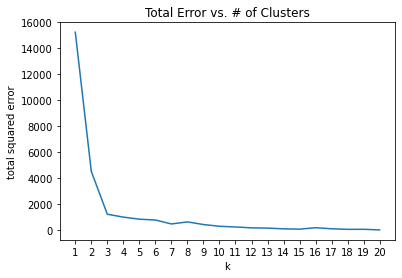

In [23]:
from matplotlib import pyplot as plt

# how to choose a right k is hard if you have multiple dimensions, a way to see if you have done right is to check the squared errors
def squared_clustering_errors(inputs: List[Vector], k: int) -> float:
    """finds the total squared error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = [clusterer.classify(input) for input in inputs]

    return sum(data_lib.squared_distance(input, means[cluster])
               for input, cluster in zip(inputs, assignments))

# now plot from 1 up to len(inputs) clusters
ks = range(1, len(inputs) + 1)
errors = [squared_clustering_errors(inputs, k) for k in ks]

plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total squared error")
plt.title("Total Error vs. # of Clusters")
plt.show()

changed: 1 / 273280: : 50it [03:09,  3.79s/it]    


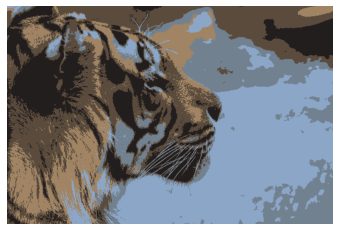

In [24]:
# let's recolor an image with just 5 colors
import matplotlib.image as mpimg
img = mpimg.imread('tiger.jpg') / 256  # rescale to between 0 and 1

top_row = img[0]
top_left_pixel = top_row[0]
red, green, blue = top_left_pixel
# .tolist() converts a NumPy array to a Python list
pixels = [pixel.tolist() for row in img for pixel in row]

clusterer = KMeans(5)
clusterer.train(pixels)   # this might take a while

def recolor(pixel: Vector) -> Vector:
    cluster = clusterer.classify(pixel)        # index of the closest cluster
    return clusterer.means[cluster]            # mean of the closest cluster

new_img = [[recolor(pixel) for pixel in row]   # recolor this row of pixels
           for row in img]                     # for each row in the image

plt.imshow(new_img)
plt.axis('off')
plt.show()

In [25]:
# another approach is to build the clusters bottom-up
class Leaf(NamedTuple):
    value: Vector

leaf1 = Leaf([10,  20])
leaf2 = Leaf([30, -15])

class Merged(NamedTuple):
    children: tuple
    order: int

merged = Merged((leaf1, leaf2), order=1)

Cluster = Union[Leaf, Merged]

def get_values(cluster: Cluster) -> List[Vector]:
    if isinstance(cluster, Leaf):
        return [cluster.value]
    else:
        return [value
                for child in cluster.children
                for value in get_values(child)]

assert get_values(merged) == [[10, 20], [30, -15]]

# we need to somehow merge the clusters with a notion of the distance
def cluster_distance(cluster1: Cluster,
                     cluster2: Cluster,
                     distance_agg: Callable = min) -> float:
    """
    compute all the pairwise distances between cluster1 and cluster2
    and apply the aggregation function _distance_agg_ to the resulting list
    """
    return distance_agg([data_lib.distance(v1, v2)
                         for v1 in get_values(cluster1)
                         for v2 in get_values(cluster2)])

def get_merge_order(cluster: Cluster) -> float:
    if isinstance(cluster, Leaf):
        return float('inf')  # was never merged
    else:
        return cluster.order

def get_children(cluster: Cluster):
    if isinstance(cluster, Leaf):
        raise TypeError("Leaf has no children")
    else:
        return cluster.children

In [26]:
# now we have the clustering algorithm
def bottom_up_cluster(inputs: List[Vector],
                      distance_agg: Callable = min) -> Cluster:
    # Start with all leaves
    clusters: List[Cluster] = [Leaf(input) for input in inputs]

    def pair_distance(pair: Tuple[Cluster, Cluster]) -> float:
        return cluster_distance(pair[0], pair[1], distance_agg)

    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min(((cluster1, cluster2)
                      for i, cluster1 in enumerate(clusters)
                      for cluster2 in clusters[:i]),
                      key=pair_distance)

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = Merged((c1, c2), order=len(clusters))

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

base_cluster = bottom_up_cluster(inputs)

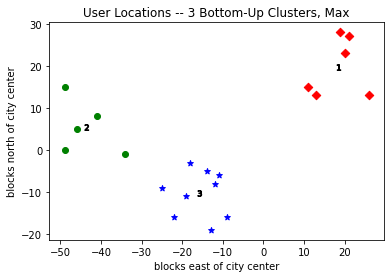

In [27]:
# instead of having text like representation, create a function that does the necessary unmerge by number
def generate_clusters(base_cluster: Cluster,
                      num_clusters: int) -> List[Cluster]:
    # start with a list with just the base cluster
    clusters = [base_cluster]
    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]

        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters

base_cluster_max = bottom_up_cluster(inputs, max)
three_clusters_max = [get_values(cluster)
                        for cluster in generate_clusters(base_cluster_max, 3)]
    
for i, cluster, marker, color in zip([1, 2, 3],
                                        three_clusters_max,
                                        ['D','o','*'],
                                        ['r','g','b']):
    xs, ys = zip(*cluster)  # magic unzipping trick
    plt.scatter(xs, ys, color=color, marker=marker)
    # put a number at the mean of the cluster
    x, y = data_lib.vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')
    
plt.title("User Locations -- 3 Bottom-Up Clusters, Max")
plt.xlabel("blocks east of city center")
plt.ylabel("blocks north of city center")
plt.show()